In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler
from my_functions import *

In [2]:
houses_train_cleaned = pd.read_csv('./datasets/cleaned/house_train_cleaned.csv')
houses_test_cleaned = pd.read_csv('./datasets/cleaned/house_test_cleaned.csv')

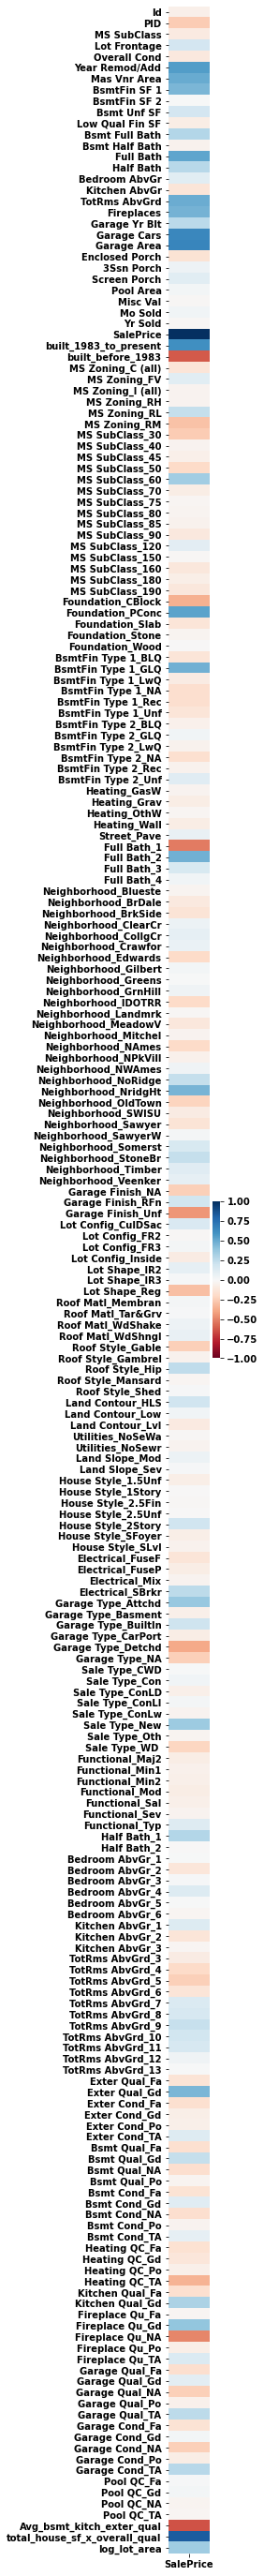

In [3]:
plt.figure(figsize=(1, 50))
sns.heatmap(houses_train_cleaned.corr()[['SalePrice']], vmin=-1, vmax=1, cmap='RdBu');

In [4]:
# random_feature_thresh_test(houses_train_cleaned, 'SalePrice', features_all, 1.5)

In [5]:
# mean_corr = houses_train_cleaned.corr()['SalePrice'].mean()
features = get_features(houses_train_cleaned, 5)
len(features)

113

In [6]:
X_real_test = houses_test_cleaned[[col for col in features if col in houses_test_cleaned]]
X_real_test.shape

(878, 110)

## Prepping model for Kaggle Submission

In [7]:
# Garage Cars was type int64 in houses_test_cleaned, was type float in houses_train_cleaned_pol_scale
houses_test_cleaned['Garage Cars'] = houses_test_cleaned['Garage Cars'].apply(lambda x: float(x))

In [8]:
houses_test_cleaned.shape

(878, 257)

## Testing!!

### Splitting the Data

In [9]:
outlier_indices = [1796, 125]
X = houses_train_cleaned[[col for col in features if col in houses_test_cleaned]].drop(outlier_indices)
y = houses_train_cleaned['SalePrice'].drop(outlier_indices)
X.shape

(2032, 110)

In [10]:
model = sm.OLS(y, X).fit()

In [51]:
significant_features = list(model.pvalues[model.pvalues < 0.05].index) # Thanks foxyblue from Stack Overflow! https://stackoverflow.com/questions/37508158/how-to-extract-a-particular-value-from-the-ols-summary-in-pandas/41212509

In [52]:
X = houses_train_cleaned[[col for col in significant_features if col in houses_test_cleaned]].drop(outlier_indices)

In [53]:
X_train, X_test, y_train, y_test = get_cval_score_mse(X, y)

The Cross Validation Score is: [0.90412332 0.90699323 0.90233269 0.89822676 0.90128556]
The R2 score on testing data is: 0.9095318892387195
The MSE is 21360.070257530046


In [32]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [33]:
y_pred = lr.predict(X_test)

In [34]:
resids = y_test - y_pred

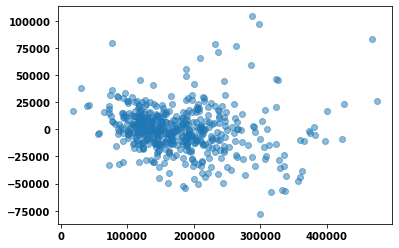

In [35]:
plt.scatter(y_pred, resids, alpha=0.5)

In [36]:
X.shape

(2032, 46)

In [37]:
sc = StandardScaler()

In [38]:
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.fit_transform(X_test)

In [22]:
ridge = Ridge(alpha=100)

In [23]:
ridge.fit(X_train_sc, y_train)

Ridge(alpha=100)

In [24]:
print(f'Train Ridge: {ridge.score(X_train_sc, y_train)}')
print(f'Test Ridge: {ridge.score(X_test_sc, y_test)}')

Train Ridge: 0.9095330534657972
Test Ridge: 0.903257333252804


## Training model on all data

In [25]:
lr.fit(X, y)

LinearRegression()

In [26]:
X_real_test = houses_test_cleaned[[col for col in significant_features if col in houses_test_cleaned]]
X_real_test.shape

(878, 52)

In [27]:
pd.DataFrame(lr.coef_, X_real_test.columns)

,0
Overall Cond,4611.963092
Year Remod/Add,97.700642
Mas Vnr Area,22.529061
BsmtFin SF 1,34.302404
Bsmt Unf SF,13.108303
Half Bath,-5207.924663
Bedroom AbvGr,-5210.655425
TotRms AbvGrd,4395.603041
Fireplaces,11296.703043
Garage Area,29.057206


In [28]:
houses_test_cleaned['SalePrice'] = lr.predict(X_real_test)

submission = houses_test_cleaned[['Id', 'SalePrice']]
submission[submission['SalePrice'] < 0]
submission.describe()

,Id,SalePrice
count,878.000000,878.000000
mean,1444.749431,179642.572936
std,850.838263,73232.787429
min,2.000000,18877.585665
25%,692.250000,129598.427794
50%,1433.000000,164907.428084
75%,2197.500000,215027.061616
max,2928.000000,509484.484651


In [154]:
submission.to_csv('./submissions/test38.csv', index=False)

In [155]:
X_real_test_sc = sc.fit_transform(X_real_test)

In [156]:
len(X_real_test)

878

In [157]:
r_alphas = np.logspace(0, 5, 100)
# Cross-validate over our list of ridge alphas.
ridge_cv = RidgeCV( 
    alphas=r_alphas,
    scoring='r2',
    cv=5
)

# Fit model using best ridge alpha!
ridge_cv.fit(X_train_sc, y_train);

In [158]:
ridge_cv.score(X_test_sc, y_test)

0.8887745690405732

In [159]:
print(f'The MSE is {metrics.mean_squared_error(y_test, ridge_cv.predict(X_test_sc), squared=False)}')

The MSE is 23684.10429593474


In [122]:
houses_test_cleaned['SalePrice'] = ridge_cv.predict(X_real_test_sc)

submission = houses_test_cleaned[['Id', 'SalePrice']]
submission[submission['SalePrice'] < 0]
submission.describe()

,Id,SalePrice
count,878.000000,878.000000
mean,1444.749431,180865.713911
std,850.838263,74375.965794
min,2.000000,22999.065511
25%,692.250000,128932.987084
50%,1433.000000,164935.769540
75%,2197.500000,216448.549845
max,2928.000000,567498.542280


In [123]:
submission.to_csv('./submissions/test39.csv', index=False)